# 서울시 자전거 수요 분석

[1. 데이터 탐색 및 전처리](#1.-데이터-탐색-및-전처리) <br>
　[1-1. 시계열 분해](#1-1.-시계열-분해)<br>
　[1-2. 이동평균 생성](#1-2.-이동평균-생성)<br>
　[1-3. 증감폭 계산](#1-3.-증감폭-계산)<br>
　[1-4. 그룹화](#1-4.-그룹화)<br>
　[1-5. 누적 분기](#1-5.-누적-분기)<br>
　[1-6. 시간 정보 추출](#1-6.-시간-정보-추출)<br>
　[1-7. 지연값 생성](#1-7.-지연값-생성)<br>
　[1-8. 더미변수 생성](#1-8.-더미변수-생성)<br>
[2. 종속변수와 독립변수의 관계 파악](#2.-종속변수와-독립변수의-관계-파악) <br>
　[2-1. 히스토그램](#2-1.-히스토그램)<br>
　[2-2. 계절별 자전거 수요 관계](#2-2.-계절별-자전거-수요-관계)<br>
　[2-3. 공휴일 여부에 따른 시간별 자전거 수요 관계](#2-3.-공휴일-여부에-따른-시간별-자전거-수요-관계)<br>
　[2-4. 평일 여부에 따른 시간별, 기온별 자전거 수요 관계](#2-4.-평일-여부에-따른-시간별,-기온별-자전거-수요-관계)<br>
　[2-5. 기온과 자전거 수요의 관계](#2-5.-기온과-자전거-수요의-관계)<br>
　[2-6. 습도, 기온과 자전거 수요의 관계](#2-6.-습도,-기온과-자전거-수요의-관계)<br>
　[2-7. 상관관계](#2-7.-상관관계)<br>
[3. 시계열 데이터 준비](#3.-시계열-데이터-준비) <br>
[4. 모델 적합 - 다중회귀](#4.-모델-적합---다중회귀) <br>

In [78]:
# 필요한 라이브러리 불러오기

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

## 1. 데이터 탐색 및 전처리

- 기본적인 데이터 전처리
- 시간현실반영
- 데이터 스케일링
- 다중공선성 제거 등

In [79]:
data = pd.read_csv('../input/bike-sharing-dataset/hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


확인해보면 날짜와 시간이 다른 열로 분리되어 있는데 이를 합쳐준다.<br>
(반복문으로 행 하나씩 변경해주었는데 이보다 더 효율적인 방법이 있을 것 같다..)

In [80]:
data['datetime'] = pd.to_datetime(data['dteday'])
for i in range(len(data['hr'])):
    data['datetime'][i] = data['datetime'][i] + timedelta(hours=int(data['hr'][i]))
data['Datetime'] = data['datetime']
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime,Datetime
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 00:00:00,2011-01-01 00:00:00
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 01:00:00,2011-01-01 01:00:00
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 02:00:00,2011-01-01 02:00:00
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01 03:00:00,2011-01-01 03:00:00
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01 04:00:00,2011-01-01 04:00:00


In [81]:
data = data.rename(columns={'cnt':'Count'})

**데이터 타입 변환**

object 형태로 되어 있는 datetime 컬럼을 datetime으로 변환하고 인덱스로 넣어준다.

In [82]:
data.set_index('datetime', inplace=True)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,Count,Datetime
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 00:00:00
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 01:00:00
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 02:00:00
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01 03:00:00
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01 04:00:00


**주기 단위 설정**

시간을 기준으로 행 인덱스를 설정한다

In [83]:
data.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17379, freq=None)

In [84]:
data.dtypes

instant                int64
dteday                object
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
Count                  int64
Datetime      datetime64[ns]
dtype: object

In [85]:
data.sort_index(inplace = True)

`asfreq`: pandas Period 객체를 원하는 주기(Period frequency)로 변환

In [86]:
data = data.asfreq('H', method='ffill')

<AxesSubplot:xlabel='datetime'>

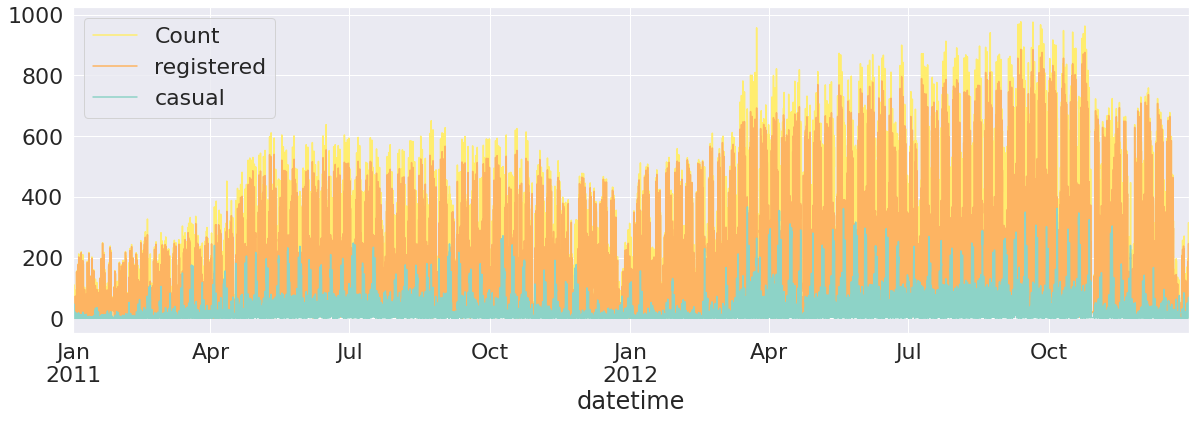

In [87]:
data[['Count', 'registered', 'casual']].plot(kind='line', figsize=(20,6), colormap='Set3_r')

<AxesSubplot:xlabel='datetime'>

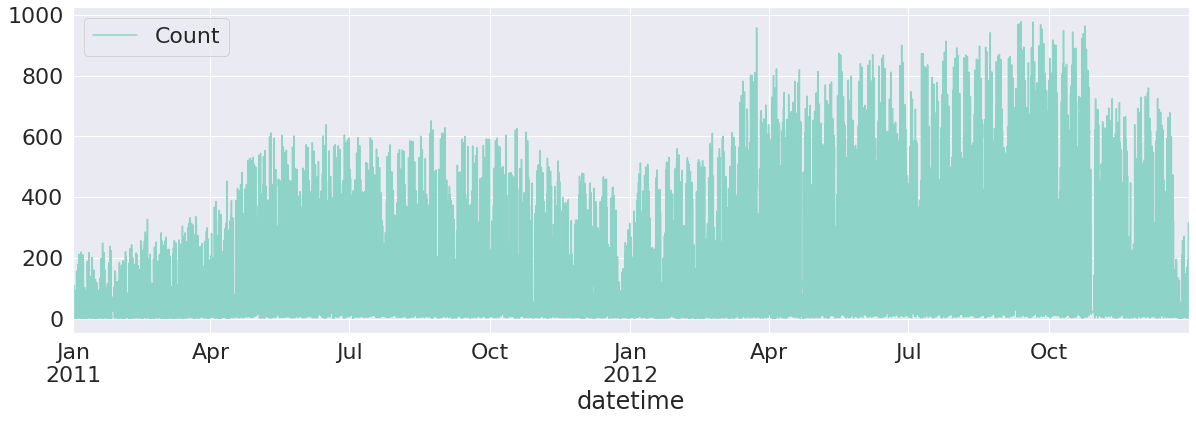

In [88]:
sns.set(palette='Set3', color_codes=True, font_scale=2)
data[['Count']].plot(kind='line', figsize=(20,6))

### 1-1. 시계열 분해

시계열 데이터를 추세, 계절성, 잔차로 분리해보자. 가법 모형을 가정하여 진행한다.

`sm.tsa` 라이브러리
- `seasonal_decompose`: 시계열 분해 

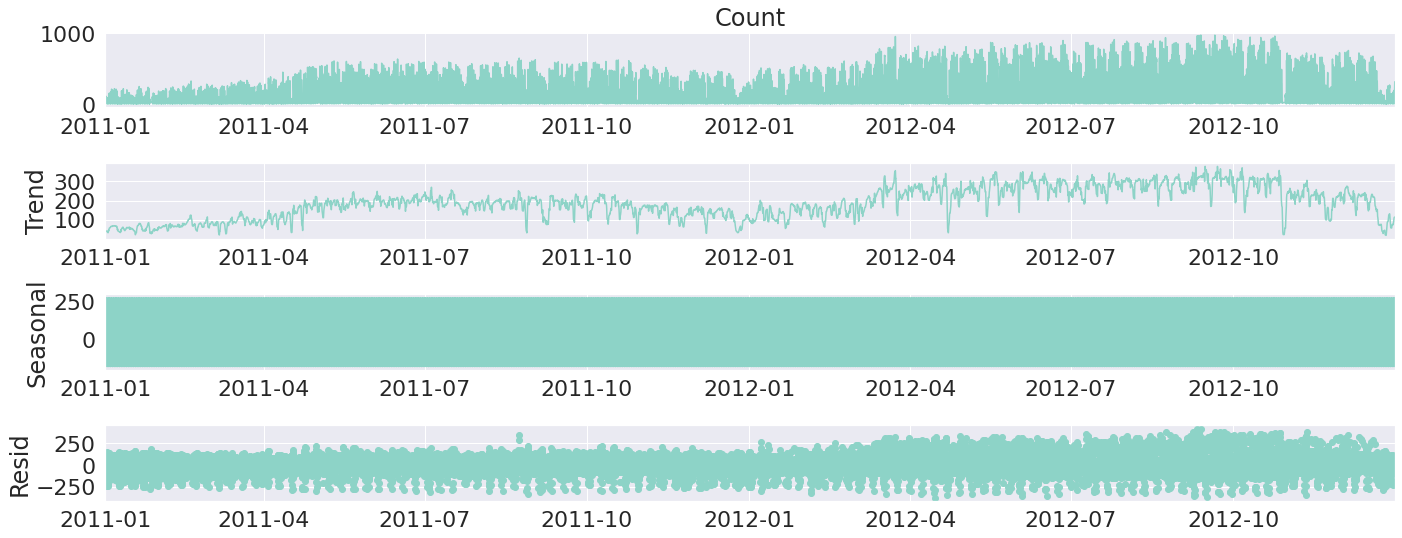

In [89]:
plt.rcParams['figure.figsize'] = (20, 8)
sm.tsa.seasonal_decompose(data['Count'], model='additive').plot()
plt.show()

In [90]:
result = sm.tsa.seasonal_decompose(data['Count'], model='additive')
result.observed

datetime
2011-01-01 00:00:00     16.0
2011-01-01 01:00:00     40.0
2011-01-01 02:00:00     32.0
2011-01-01 03:00:00     13.0
2011-01-01 04:00:00      1.0
                       ...  
2012-12-31 19:00:00    119.0
2012-12-31 20:00:00     89.0
2012-12-31 21:00:00     90.0
2012-12-31 22:00:00     61.0
2012-12-31 23:00:00     49.0
Freq: H, Name: Count, Length: 17544, dtype: float64

분리한 추세와 계절성을 데이터 프레임으로 생성하고 기존 데이터와 합쳐준다

In [91]:
y_trend = pd.DataFrame(result.trend)
y_trend.fillna(method='ffill', inplace=True)
y_trend.fillna(method='bfill', inplace=True)
y_trend.columns = ['Count_trend']

y_seasonal = pd.DataFrame(result.seasonal)
y_seasonal.fillna(method='ffill', inplace=True)
y_seasonal.fillna(method='bfill', inplace=True)
y_seasonal.columns = ['Count_seasonal'] 

data = pd.concat([data, y_trend, y_seasonal], axis=1)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,Count,Datetime,Count_trend,Count_seasonal
datetime,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 00:00:00,41.0625,-134.252007
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 01:00:00,41.0625,-154.752264
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 02:00:00,41.0625,-165.274467
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01 03:00:00,41.0625,-176.484342
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01 04:00:00,41.0625,-181.666248


### 1-2. 이동평균 생성



시간, 하루, 일주일로 이동평균을 구하고 시각화해보면 다음과 같다.

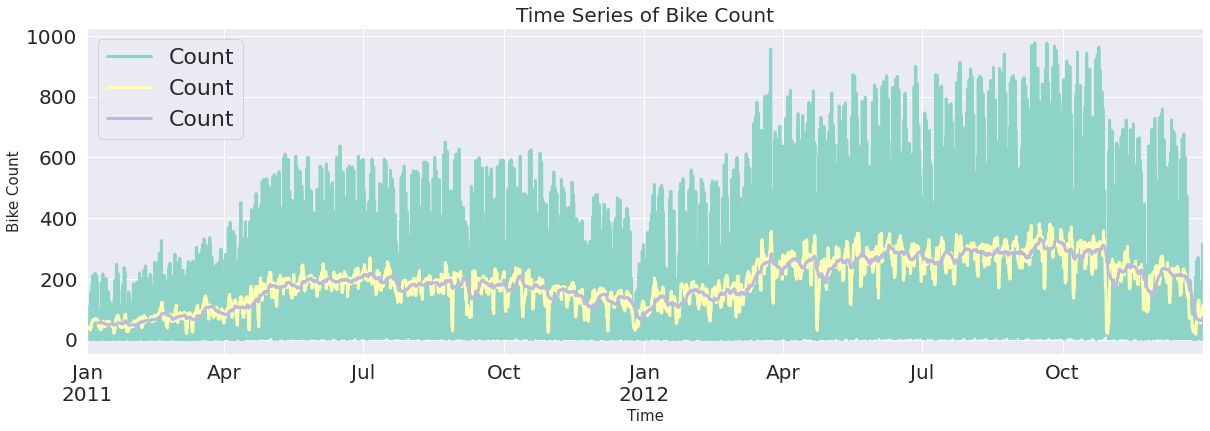

In [92]:
pd.concat([data[['Count']],
           data[['Count']].rolling(24).mean(),
           data[['Count']].rolling(24*7).mean()], axis=1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20) 
plt.title('Time Series of Bike Count', fontsize=20) 
plt.xlabel('Time', fontsize=15) 
plt.ylabel('Bike Count', fontsize=15) 
plt.show()

이 이동평균 값들을 기존 데이터프레임에 추가한다.

In [93]:
y_count_Day = data[['Count']].rolling(24).mean() 
y_count_Day.fillna(method='ffill', inplace=True) 
y_count_Day.fillna(method='bfill', inplace=True) 
y_count_Day.columns = ['Count_day'] 

y_count_Week = data[['Count']].rolling(24*7).mean() 
y_count_Week.fillna(method='ffill', inplace=True) 
y_count_Week.fillna(method='bfill', inplace=True) 
y_count_Week.columns = ['Count_week']

data = pd.concat([data, y_count_Day, y_count_Week], axis=1)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,hum,windspeed,casual,registered,Count,Datetime,Count_trend,Count_seasonal,Count_day,Count_week
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.81,0.0,3,13,16,2011-01-01 00:00:00,41.0625,-134.252007,41.041667,56.107143
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.80,0.0,8,32,40,2011-01-01 01:00:00,41.0625,-154.752264,41.041667,56.107143
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.80,0.0,5,27,32,2011-01-01 02:00:00,41.0625,-165.274467,41.041667,56.107143
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.75,0.0,3,10,13,2011-01-01 03:00:00,41.0625,-176.484342,41.041667,56.107143
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.75,0.0,0,1,1,2011-01-01 04:00:00,41.0625,-181.666248,41.041667,56.107143


### 1-3. 증감폭 계산

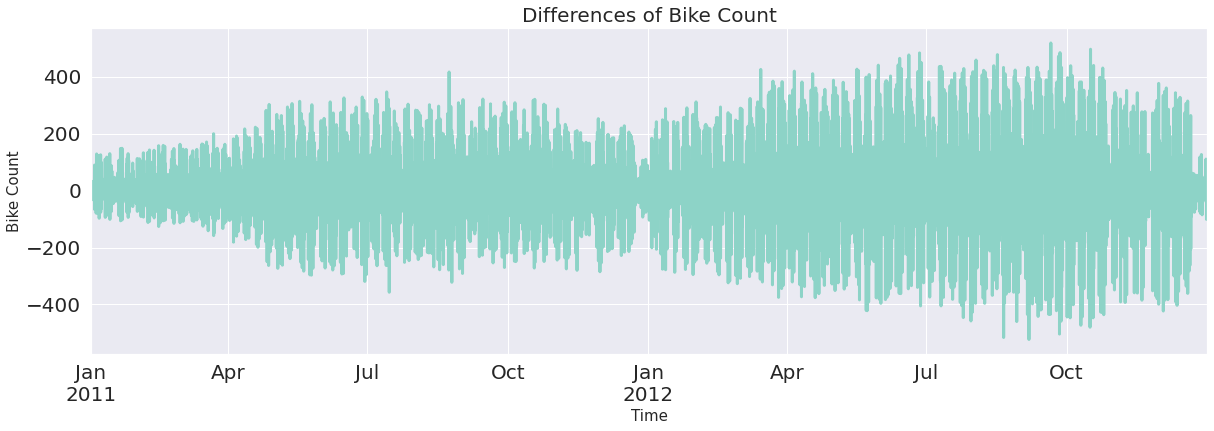

In [94]:
data['Count'].diff().plot(kind='line', figsize=(20, 6), linewidth=3, fontsize=20)
plt.title('Differences of Bike Count', fontsize=20) 
plt.xlabel('Time', fontsize=15) 
plt.ylabel('Bike Count', fontsize=15) 
plt.show()

In [95]:
y_diff = data[['Count']].diff() 
y_diff.fillna(method='ffill', inplace=True)
y_diff.fillna(method='bfill', inplace=True)
y_diff.columns = ['Count_diff']

data = pd.concat([data, y_diff], axis=1)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,Count,Datetime,Count_trend,Count_seasonal,Count_day,Count_week,Count_diff
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.0,3,13,16,2011-01-01 00:00:00,41.0625,-134.252007,41.041667,56.107143,24.0
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.0,8,32,40,2011-01-01 01:00:00,41.0625,-154.752264,41.041667,56.107143,24.0
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.0,5,27,32,2011-01-01 02:00:00,41.0625,-165.274467,41.041667,56.107143,-8.0
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.0,3,10,13,2011-01-01 03:00:00,41.0625,-176.484342,41.041667,56.107143,-19.0
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.0,0,1,1,2011-01-01 04:00:00,41.0625,-181.666248,41.041667,56.107143,-12.0


### 1-4. 그룹화

Temperature (기온)를 기준으로 5개 그룹으로 그룹화해보자.

In [96]:
pd.cut(data['temp'], 5)

datetime
2011-01-01 00:00:00    (0.216, 0.412]
2011-01-01 01:00:00    (0.216, 0.412]
2011-01-01 02:00:00    (0.216, 0.412]
2011-01-01 03:00:00    (0.216, 0.412]
2011-01-01 04:00:00    (0.216, 0.412]
                            ...      
2012-12-31 19:00:00    (0.216, 0.412]
2012-12-31 20:00:00    (0.216, 0.412]
2012-12-31 21:00:00    (0.216, 0.412]
2012-12-31 22:00:00    (0.216, 0.412]
2012-12-31 23:00:00    (0.216, 0.412]
Freq: H, Name: temp, Length: 17544, dtype: category
Categories (5, interval[float64]): [(0.019, 0.216] < (0.216, 0.412] < (0.412, 0.608] < (0.608, 0.804] < (0.804, 1.0]]

In [97]:
data['Temperature_Group'] = pd.cut(data['temp'], 5)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,casual,registered,Count,Datetime,Count_trend,Count_seasonal,Count_day,Count_week,Count_diff,Temperature_Group
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,...,3,13,16,2011-01-01 00:00:00,41.0625,-134.252007,41.041667,56.107143,24.0,"(0.216, 0.412]"
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,...,8,32,40,2011-01-01 01:00:00,41.0625,-154.752264,41.041667,56.107143,24.0,"(0.216, 0.412]"
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,...,5,27,32,2011-01-01 02:00:00,41.0625,-165.274467,41.041667,56.107143,-8.0,"(0.216, 0.412]"
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,...,3,10,13,2011-01-01 03:00:00,41.0625,-176.484342,41.041667,56.107143,-19.0,"(0.216, 0.412]"
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,...,0,1,1,2011-01-01 04:00:00,41.0625,-181.666248,41.041667,56.107143,-12.0,"(0.216, 0.412]"


### 1-5. 누적 분기 

데이터에서 연도와 분기를 추출한 후 누적 분기를 구한다.
- 분기: 연도의 구분이 없으므로 순수 분기에 따른 해석을 할 수 있다
- 누적 분기: 연도의 구분이 포함된 것으로 연도의 분기에 따른 해석을 할 수 있다

In [98]:
data['Year'] = data.Datetime.dt.year
data['Quater'] = data.Datetime.dt.quarter

data['Quater_cum'] = data.Quater + (data.Year - data.Year.min()) * 4
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,Datetime,Count_trend,Count_seasonal,Count_day,Count_week,Count_diff,Temperature_Group,Year,Quater,Quater_cum
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,...,2011-01-01 00:00:00,41.0625,-134.252007,41.041667,56.107143,24.0,"(0.216, 0.412]",2011,1,1
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,...,2011-01-01 01:00:00,41.0625,-154.752264,41.041667,56.107143,24.0,"(0.216, 0.412]",2011,1,1
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,...,2011-01-01 02:00:00,41.0625,-165.274467,41.041667,56.107143,-8.0,"(0.216, 0.412]",2011,1,1
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,...,2011-01-01 03:00:00,41.0625,-176.484342,41.041667,56.107143,-19.0,"(0.216, 0.412]",2011,1,1
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,...,2011-01-01 04:00:00,41.0625,-181.666248,41.041667,56.107143,-12.0,"(0.216, 0.412]",2011,1,1


### 1-6. 시간 정보 추출

In [99]:
data['Month'] = data.Datetime.dt.month
data['Day'] = data.Datetime.dt.day
data['Hour'] = data.Datetime.dt.hour
data['DayofWeek'] = data.Datetime.dt.dayofweek
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,Count_week,Count_diff,Temperature_Group,Year,Quater,Quater_cum,Month,Day,Hour,DayofWeek
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,...,56.107143,24.0,"(0.216, 0.412]",2011,1,1,1,1,0,5
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,...,56.107143,24.0,"(0.216, 0.412]",2011,1,1,1,1,1,5
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,...,56.107143,-8.0,"(0.216, 0.412]",2011,1,1,1,1,2,5
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,...,56.107143,-19.0,"(0.216, 0.412]",2011,1,1,1,1,3,5
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,...,56.107143,-12.0,"(0.216, 0.412]",2011,1,1,1,1,4,5


### 1-7. 지연값 생성

- `shift(1)`: 1시간 지연값으로 한 행 지연된 값이며 오름차순으로 나타낸다
- `shift(-2)`: 2시간 앞선 값으로 두 행 앞선 값이며 내림차순으로 나타낸다

여기에서는 1시간 지연된 값과 2시간 지연된 값을 생성해보자.<br>
지연값은 앞의 값이 비게 되므로 bfill로 채워준다.

In [100]:
data['Count_lag1'] = data[['Count']].shift(1)
data['Count_lag1'].fillna(method='bfill', inplace=True)

data['Count_lag2'] = data[['Count']].shift(2)
data['Count_lag2'].fillna(method='bfill', inplace=True)

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,Temperature_Group,Year,Quater,Quater_cum,Month,Day,Hour,DayofWeek,Count_lag1,Count_lag2
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,...,"(0.216, 0.412]",2011,1,1,1,1,0,5,16.0,16.0
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,...,"(0.216, 0.412]",2011,1,1,1,1,1,5,16.0,16.0
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,...,"(0.216, 0.412]",2011,1,1,1,1,2,5,40.0,16.0
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,...,"(0.216, 0.412]",2011,1,1,1,1,3,5,32.0,40.0
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,...,"(0.216, 0.412]",2011,1,1,1,1,4,5,13.0,32.0


### 1-8. 더미변수 생성

범주형 변수인 분기 변수에 대해 더미변수를 생성하자

`get_dummies`
- `prefix`: 컬럼에 이름 붙이기
- `drop_first`: 더미 카테고리 개수 -1 만큼 필요한 경우 사용

In [101]:
data = pd.concat([data, pd.get_dummies(data['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,Quater_cum,Month,Day,Hour,DayofWeek,Count_lag1,Count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,...,1,1,1,0,5,16.0,16.0,0,0,0
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,...,1,1,1,1,5,16.0,16.0,0,0,0
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,...,1,1,1,2,5,40.0,16.0,0,0,0
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,...,1,1,1,3,5,32.0,40.0,0,0,0
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,...,1,1,1,4,5,13.0,32.0,0,0,0


## 2. 종속변수와 독립변수의 관계 파악

다양한 시각화를 통해 자전거 수요와 관련 있는 변수 간의 관계를 파악해보자.

### 2-1. 히스토그램

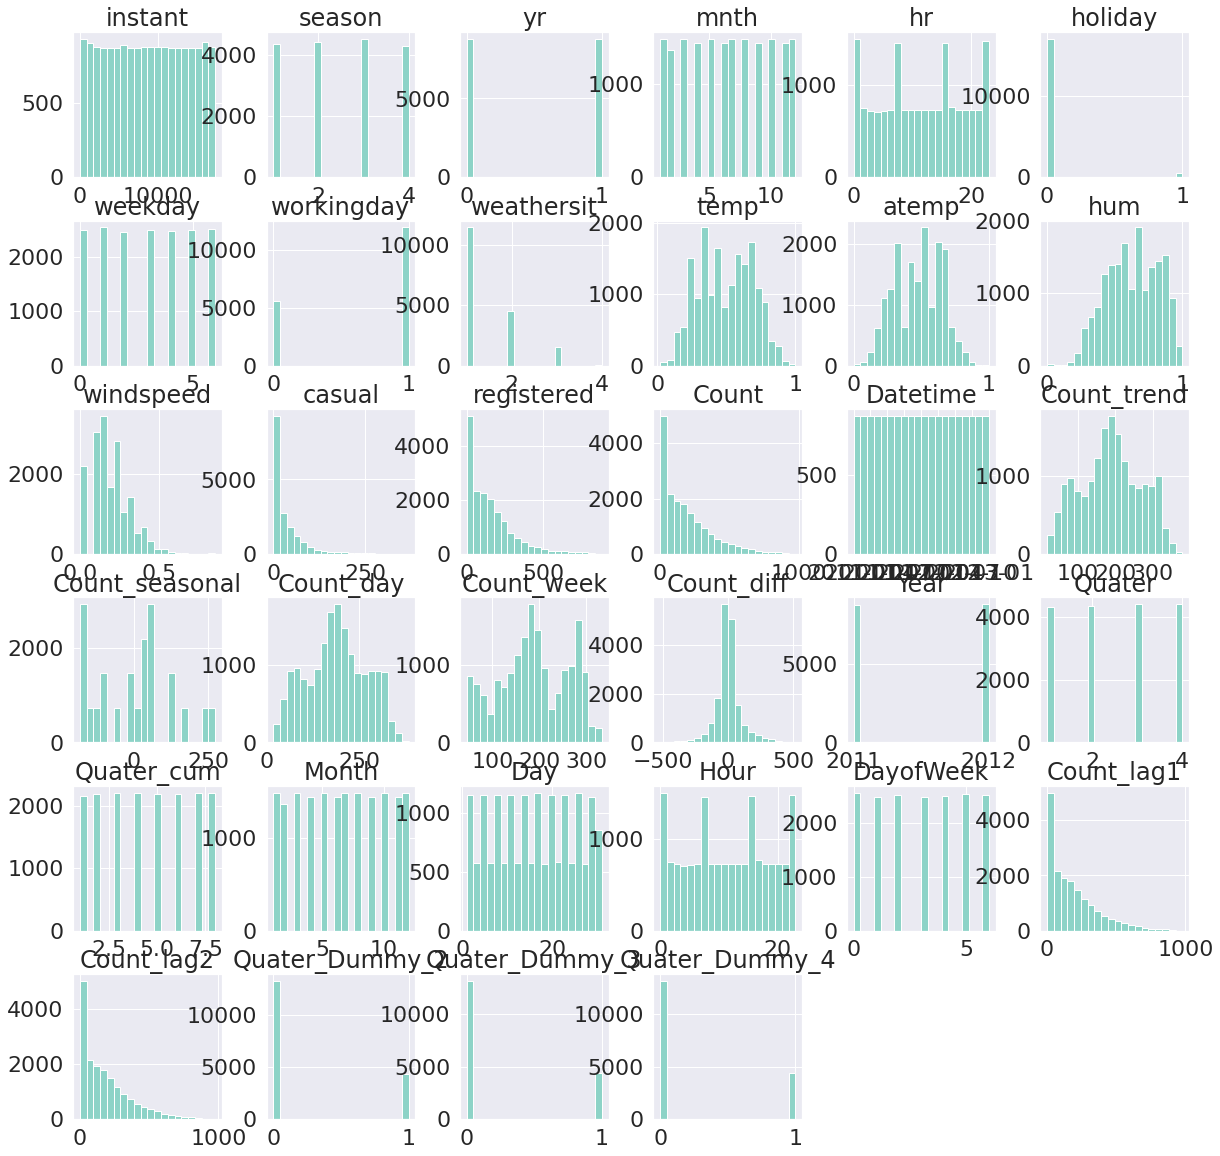

In [102]:
data.hist(bins=20, grid=True, figsize=(20, 20))
plt.show()

### 2-2. 계절별 자전거 수요 관계

Seasons - Count

<AxesSubplot:title={'center':'Count'}, xlabel='season'>

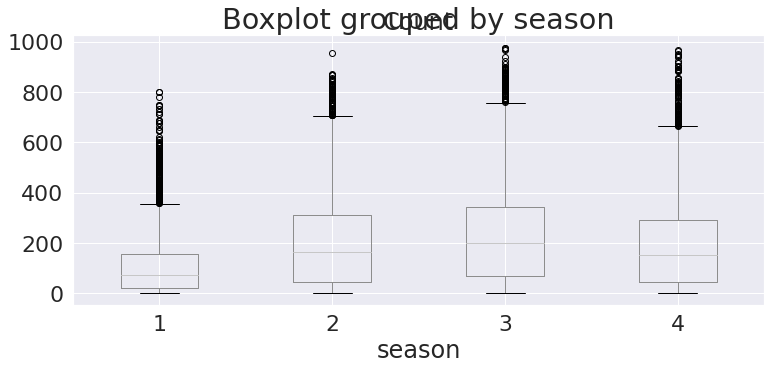

In [103]:
data.boxplot(column='Count', by='season', grid=True, figsize=(12, 5))

### 2-3. 공휴일 여부에 따른 시간별 자전거 수요 관계

Hour - Count

<AxesSubplot:title={'center':'Count'}, xlabel='Hour'>

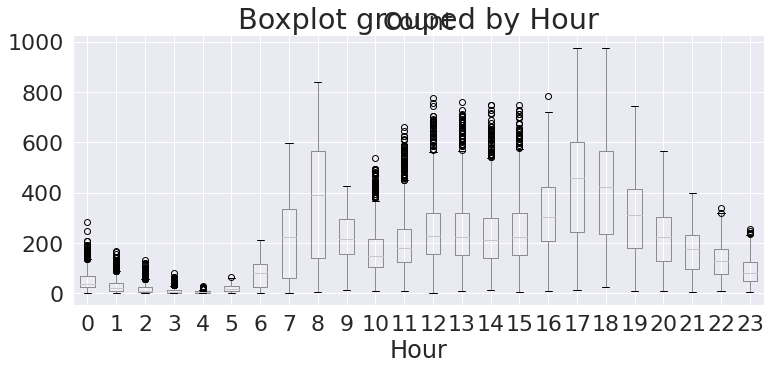

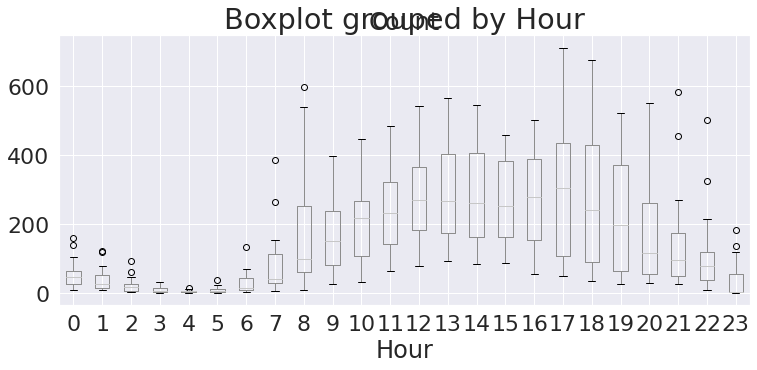

In [104]:
data[data.holiday == 0].boxplot(column='Count', by='Hour', grid=True, figsize=(12, 5))
data[data.holiday == 1].boxplot(column='Count', by='Hour', grid=True, figsize=(12, 5))

<AxesSubplot:xlabel='Hour', ylabel='Count'>

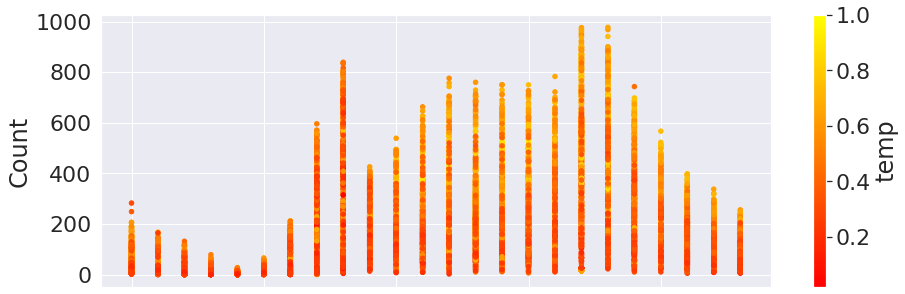

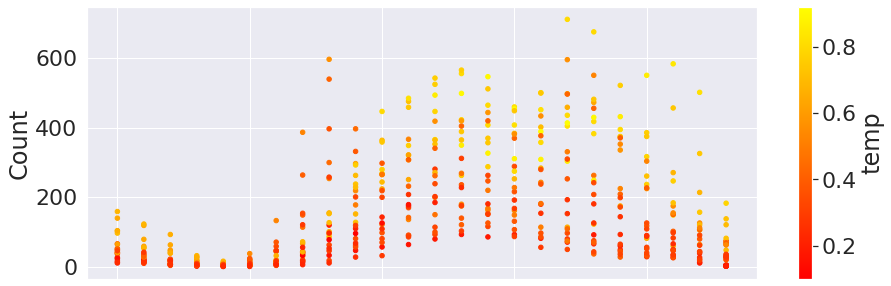

In [105]:
data[data.holiday == 0].plot.scatter(y='Count', x='Hour', c='temp', grid=True, figsize=(15, 5), colormap='autumn')
data[data.holiday == 1].plot.scatter(y='Count', x='Hour', c='temp', grid=True, figsize=(15, 5), colormap='autumn')

### 2-4. 평일 여부에 따른 시간별, 기온별 자전거 수요 관계

Hour - Temperature- Count

<AxesSubplot:xlabel='Hour', ylabel='Count'>

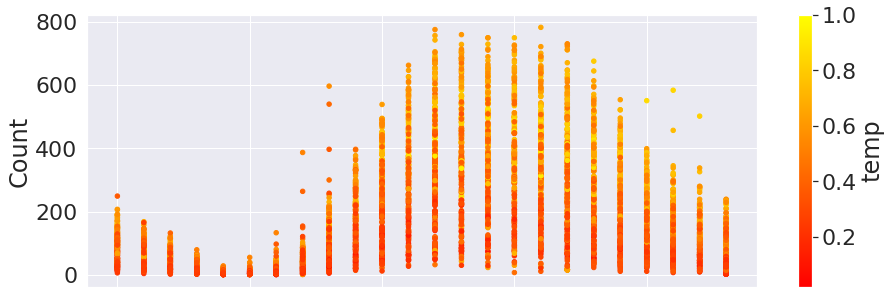

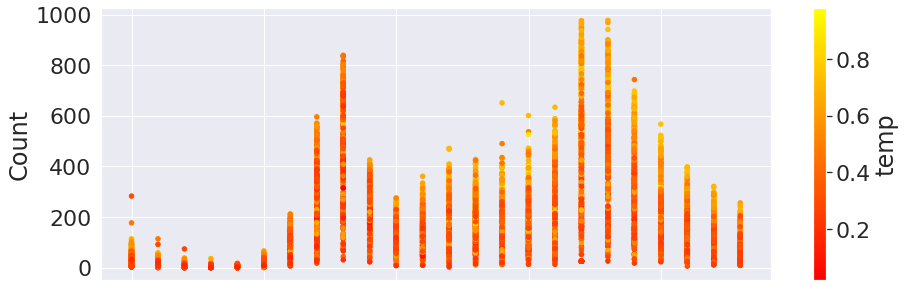

In [106]:
data[data.workingday == 0].plot.scatter(y='Count', x='Hour', c='temp', grid=True, figsize=(15, 5), colormap='autumn')
data[data.workingday == 1].plot.scatter(y='Count', x='Hour', c='temp', grid=True, figsize=(15, 5), colormap='autumn')

### 2-5. 기온과 자전거 수요의 관계

Temperature - Count

<AxesSubplot:title={'center':'Count'}, xlabel='temp'>

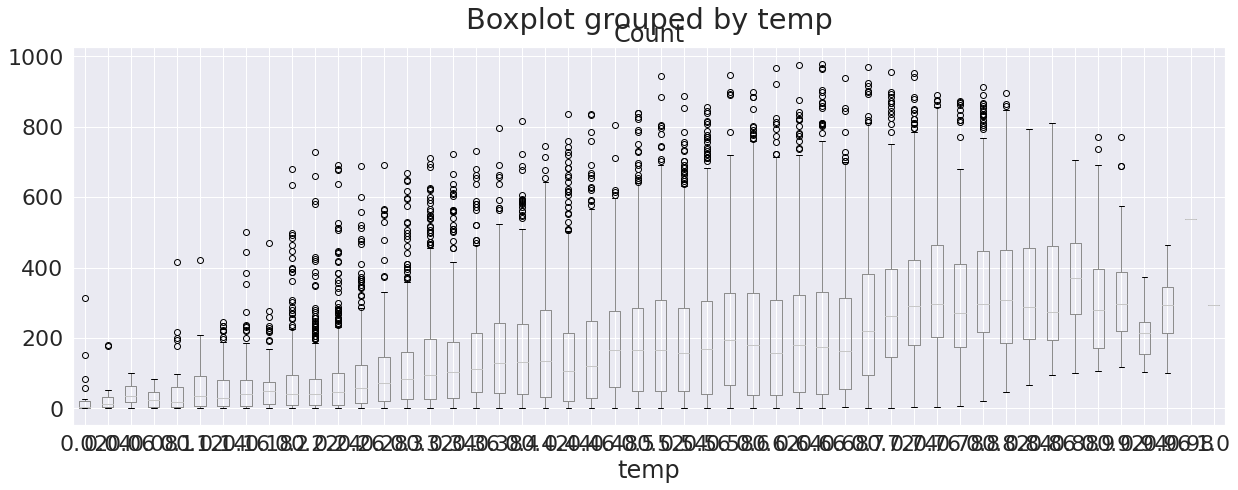

In [107]:
data.boxplot(column='Count', by='temp', grid=True, figsize=(20, 7))

### 2-6. 습도, 기온과 자전거 수요의 관계

Temperature - Humidity - Count

<AxesSubplot:xlabel='hum', ylabel='Count'>

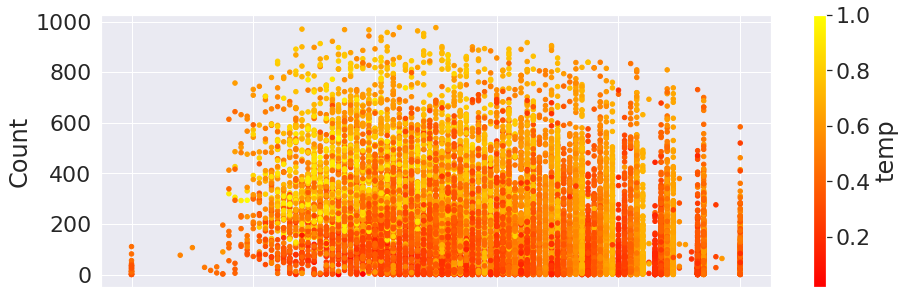

In [108]:
data.plot.scatter(y='Count', x='hum', c='temp', grid=True, figsize=(15, 5), colormap='autumn')

### 2-7. 상관관계

- `plotting.scatter_matrix` 
    - `dagonal='kde'`: 각 변수별 커널밀도추정곡선

In [109]:
# pd.plotting.scatter_matrix(data, figsize=(18, 18), diagonal='kde')

In [110]:
data.corr().style.background_gradient().set_precision(2)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,Count,Count_trend,Count_seasonal,Count_day,Count_week,Count_diff,Year,Quater,Quater_cum,Month,Day,Hour,DayofWeek,Count_lag1,Count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
instant,1.00,0.41,0.87,0.50,-0.01,0.01,0.00,-0.00,-0.02,0.14,0.15,0.01,-0.08,0.16,0.28,0.28,0.63,0.00,0.64,0.72,-0.00,0.87,0.48,0.99,0.50,0.05,-0.01,0.00,0.28,0.28,-0.13,0.12,0.37
season,0.41,1.00,-0.00,0.83,-0.01,-0.02,-0.00,0.02,-0.02,0.32,0.33,0.15,-0.14,0.12,0.18,0.18,0.41,-0.00,0.41,0.47,-0.00,-0.00,0.86,0.42,0.83,-0.00,-0.01,-0.01,0.18,0.18,-0.20,0.31,0.60
yr,0.87,-0.00,1.00,-0.00,-0.01,0.00,-0.01,0.00,-0.02,0.05,0.05,-0.08,-0.01,0.14,0.26,0.25,0.57,-0.00,0.57,0.63,-0.00,1.00,-0.00,0.87,-0.00,0.00,-0.01,-0.00,0.25,0.25,-0.00,-0.00,-0.00
mnth,0.50,0.83,-0.00,1.00,-0.01,0.01,0.01,-0.00,0.00,0.21,0.22,0.16,-0.13,0.07,0.13,0.12,0.28,0.00,0.29,0.35,-0.00,-0.00,0.97,0.47,1.00,0.01,-0.01,0.00,0.12,0.12,-0.25,0.25,0.75
hr,-0.01,-0.01,-0.01,-0.01,1.00,0.01,0.00,-0.00,-0.02,0.14,0.13,-0.27,0.14,0.30,0.37,0.39,-0.00,0.55,-0.00,-0.01,-0.14,-0.01,-0.01,-0.01,-0.01,-0.00,1.00,0.00,0.47,0.52,-0.00,0.00,-0.01
holiday,0.01,-0.02,0.00,0.01,0.01,1.00,-0.11,-0.26,-0.00,-0.04,-0.04,-0.01,0.01,0.03,-0.05,-0.04,-0.08,-0.00,-0.07,-0.04,-0.00,0.00,0.02,0.01,0.01,-0.01,0.01,-0.19,-0.04,-0.04,-0.03,-0.03,0.05
weekday,0.00,-0.00,-0.01,0.01,0.00,-0.11,1.00,0.04,-0.00,0.00,-0.00,-0.04,0.01,0.03,0.02,0.03,0.07,-0.00,0.06,0.00,0.01,-0.01,0.00,-0.00,0.01,-0.00,0.00,0.25,0.03,0.03,0.00,0.00,0.00
workingday,-0.00,0.02,0.00,-0.00,-0.00,-0.26,0.04,1.00,0.04,0.05,0.05,0.02,-0.02,-0.30,0.13,0.03,0.04,0.00,0.02,0.02,0.01,0.00,-0.01,-0.00,-0.00,0.01,-0.00,-0.70,0.03,0.02,0.01,0.01,-0.02
weathersit,-0.02,-0.02,-0.02,0.00,-0.02,-0.00,-0.00,0.04,1.00,-0.11,-0.11,0.43,0.05,-0.16,-0.13,-0.15,-0.25,-0.00,-0.17,-0.07,-0.02,-0.02,-0.00,-0.02,0.00,0.01,-0.02,-0.06,-0.14,-0.14,-0.03,-0.07,0.05
temp,0.14,0.32,0.05,0.21,0.14,-0.04,0.00,0.05,-0.11,1.00,0.99,-0.07,-0.02,0.46,0.34,0.41,0.60,0.17,0.61,0.62,-0.00,0.05,0.21,0.14,0.21,0.02,0.14,-0.03,0.41,0.40,0.26,0.60,-0.31


**종속변수와 독립변수 간의 상관관계**

In [111]:
data.corr().loc[:, ['Count', 'registered', 'casual']].style.background_gradient().set_precision(2)

,Count,registered,casual
instant,0.28,0.28,0.16
season,0.18,0.18,0.12
yr,0.25,0.26,0.14
mnth,0.12,0.13,0.07
hr,0.39,0.37,0.30
holiday,-0.04,-0.05,0.03
weekday,0.03,0.02,0.03
workingday,0.03,0.13,-0.30
weathersit,-0.15,-0.13,-0.16
temp,0.41,0.34,0.46


## 3. 시계열 데이터 준비

시계열 데이터의 경우 랜덤하게 데이터를 나누면 안되고 시간 순서 유지가 중요하다!<br>

- Training Set: 가장 오래된 데이터
- Validation Set: 그 다음의 최근 데이터
- Test Set: 가장 최신의 데이터

In [112]:
data_train = data.loc[data.index < '2012-07-01', :]
data_test = data.loc[data.index > '2012-07-01', :]
print(data_train.shape, data_test.shape)

(13128, 36) (4415, 36)


In [113]:
y_train = pd.DataFrame(data_train['Count'])
X_train = data_train.drop(['Count', 'Datetime', 'Temperature_Group', 'casual', 'registered', 'dteday', 'instant'], axis=1)
y_test = pd.DataFrame(data_test['Count'])
X_test = data_test.drop(['Count', 'Datetime', 'Temperature_Group', 'casual', 'registered', 'dteday', 'instant'], axis=1)
print('X_train: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)

X_train:  (13128, 29) y_train:  (13128, 1)
X_test:  (4415, 29) y_test:  (4415, 1)


In [114]:
def data_split(data):
    data_train = data.loc[data.index < '2012-07-01', :]
    data_test = data.loc[data.index > '2012-07-01', :]
    y_train = pd.DataFrame(data_train['Count'])
    X_train = data_train.drop(['Count', 'Datetime', 'Temperature_Group', 'casual', 'registered', 'dteday', 'instant'], axis=1)
    y_test = pd.DataFrame(data_test['Count'])
    X_test = data_test.drop(['Count', 'Datetime', 'Temperature_Group', 'casual', 'registered', 'dteday', 'instant'], axis=1)
    return X_train, y_train, X_test, y_test

## 4. 모델 적합 - 다중회귀

OLS 방식의 기본 다중 회귀를 수행한다

In [115]:
fit_reg1 = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()

pred_train_reg1 = fit_reg1.predict(X_train).values
pred_test_reg1 = fit_reg1.predict(X_test).values

회귀모델 적합 결과 R-square는 1로 데이터를 모두 반영하지만 독립변수들의 p-value를 보면 유의한 변수라고 판단할 만한 것이 없다. 또한, 잔차분석의 왜도와 첨도를 보면 정규분포가 각각 0, 3인 것을 감안하면 꽤 극단적임을 알 수 있다. 따라서 모델 적합이 잘 되지 않았다고 판단할 수 있다.

In [116]:
fit_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.223e+08
Date:                Wed, 18 Aug 2021   Prob (F-statistic):               0.00
Time:                        15:21:21   Log-Likelihood:                 1908.3
No. Observations:               13128   AIC:                            -3767.
Df Residuals:                   13103   BIC:                            -3580.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0007      0.004     -0.180      0.857      -0.009       0.007
yr                 0.0007      0.002      0.383      0.702      -0.003       0.005
mnth               0.0013      0.001      1.077      0.282      -0.001       0.004
hr                 0.0003      0.000      1.546      0.122   -7.45e-05       0.001
holiday            0.0121      0.014      0.884      0.377      -0.015       0.039
weekday           -0.0021      0.001     -2.062      0.039      -0.004      -0.000
workingday         0.0125      0.007      1.783      0.075      -0.001       0.026
weathersit         0.0047      0.003      1.371      0.170      -0.002       0.012
temp               0.0919      0.086      1.075      0.283      -0.076       0.260
atemp             -0.1254      0.092     -1.365      0.172      -0.306       0.055
hum               -0.0110      0.012     -0.907      0.364      -0.035       0.013
windspeed          0.0182      0.017      1.098      0.272      -0.014       0.051
Count_trend        0.0001    8.6e-05      1.226      0.220   -6.31e-05       0.000
Count_seasonal  1.921e-05   2.56e-05      0.750      0.453    -3.1e-05    6.94e-05
Count_day       3.813e-05   8.36e-05      0.456      0.648      -0.000       0.000
Count_week     -4.649e-05   9.61e-05     -0.484      0.629      -0.000       0.000
Count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.464e-05   7.64e-06     -1.916      0.055   -2.96e-05    3.41e-07
Quater            -0.0029      0.007     -0.404      0.687      -0.017       0.011
Quater_cum      5.853e-05      0.002      0.030      0.976      -0.004       0.004
Month              0.0013      0.001      1.077      0.282      -0.001       0.004
Day                0.0004      0.000      1.760      0.078   -4.22e-05       0.001
Hour               0.0003      0.000      1.546      0.122   -7.45e-05       0.001
DayofWeek          0.0017      0.002      1.010      0.312      -0.002       0.005
Count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
Count_lag2     -1.927e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2     0.0020      0.006      0.362      0.717      -0.009       0.013
Quater_Dummy_3     0.0028      0.005      0.534      0.593      -0.008       0.013
Quater_Dummy_4    -0.0035      0.005     -0.705      0.481      -0.013       0.006
==============================================================================
Omnibus:                    54417.891   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93430711929.844
Skew:                        -114.199   Prob(JB):                         0.00
Kurtosis:                   13070.269   Cond. No.                     1.11e+16
================================

### 4-1. 모델 성능 평가

In [117]:
data_pred = pd.concat([y_train, pd.DataFrame(pred_train_reg1, index=y_train.index, columns=['prediction'])], axis=1)
data_pred

,Count,prediction
datetime,,
2011-01-01 00:00:00,16,39.947171
2011-01-01 01:00:00,40,39.947511
2011-01-01 02:00:00,32,31.948359
2011-01-01 03:00:00,13,12.949153
2011-01-01 04:00:00,1,0.949879
...,...,...
2012-06-30 19:00:00,374,373.996041
2012-06-30 20:00:00,292,291.991629
2012-06-30 21:00:00,213,212.991495


<AxesSubplot:xlabel='datetime'>

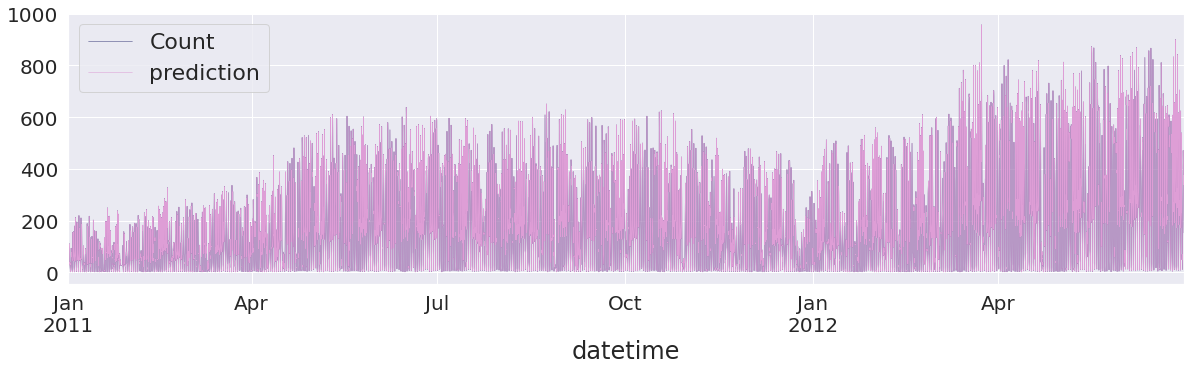

In [118]:
data_pred.plot(kind='line', figsize=(20, 5), xlim=(y_train.index.min(), y_train.index.max()), linewidth=0.5, fontsize=20, colormap='tab20b')

`flatten`: 2차원 array를 1차원으로 바꾸기

In [119]:
MAE = abs(y_train.values.flatten() - pred_train_reg1).mean()
MSE = ((y_train.values.flatten() - pred_train_reg1)**2).mean()
MAPE = (abs(y_train.values.flatten() - pred_train_reg1)/ y_train.values.flatten()*100).mean()
print('MAE: {:.2f}\nMSE: {:.2f}\nMAPE: {:.2f}'.format(MAE, MSE, MAPE))

MAE: 0.01
MSE: 0.04
MAPE: 0.06


In [120]:
def evaluation(y_train, pred_train):
    MAE = abs(y_train.values.flatten() - pred_train).mean()
    MSE = ((y_train.values.flatten() - pred_train)**2).mean()
    MAPE = (abs(y_train.values.flatten() - pred_train)/ y_train.values.flatten()*100).mean()
    return MAE, MSE, MAPE

### 4-2. 잔차진단

In [121]:
resid_train_reg1 = pd.DataFrame(y_train.values.flatten() - pred_train_reg1, index=y_train.index, columns=['Error'])
resid_test_reg1 = pd.DataFrame(y_test.values.flatten() - pred_test_reg1, index=y_test.index, columns=['Error'])

**White Noise**

White Noise가 아니다: 추세가 존재한다

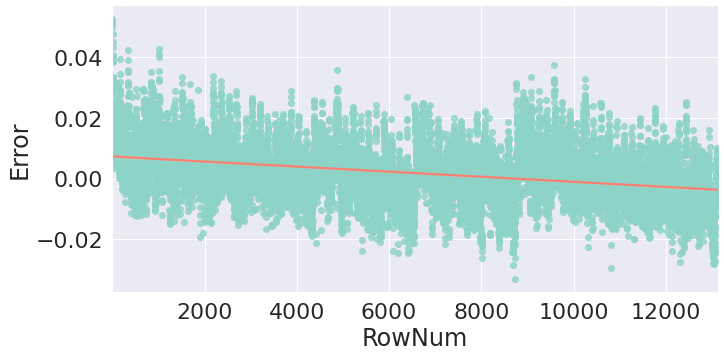

In [122]:
resid_train_reg1['RowNum'] = resid_train_reg1.reset_index().index
sns.set(palette='Set3', color_codes=True, font_scale=2)
sns.lmplot(data=resid_train_reg1.iloc[1:], x='RowNum', y='Error', fit_reg=True, line_kws={'color': 'salmon'}, size=5.1, aspect=2, ci=99, sharey=True)

**정규분포**

<AxesSubplot:xlabel='Error', ylabel='Density'>

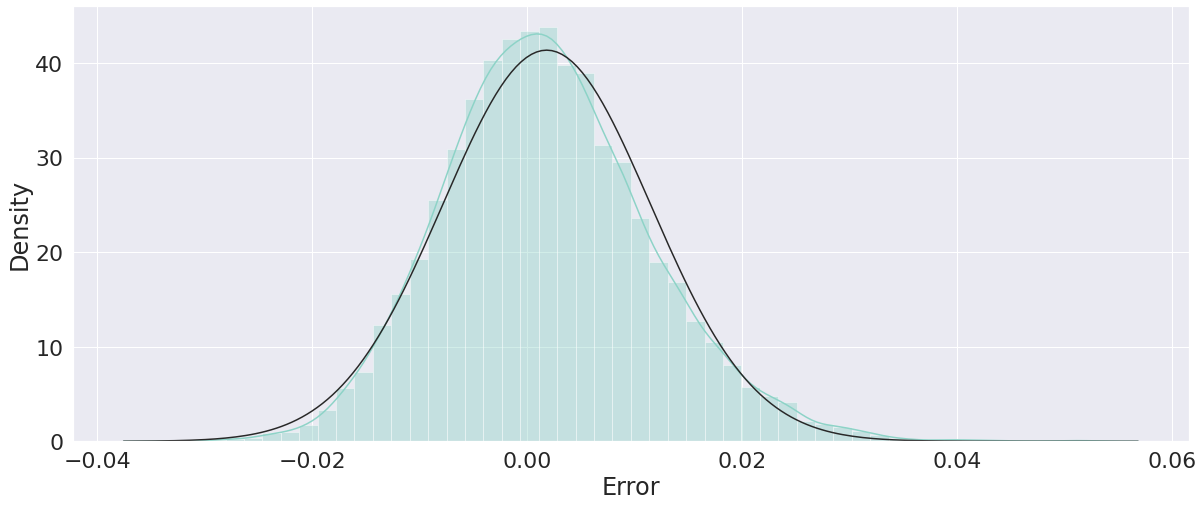

In [123]:
sns.distplot(resid_train_reg1['Error'].iloc[1:], norm_hist='True', fit=stats.norm)

**자기상관관계**

- `pd.plotting.lag_plot`: 시차에 따른 그래프<br>

- `sm.graphics.tsa.plot_acf`: 자기상관함수 ACF
- `sm.graphics.tsa.plot_pacf`: 편자기상관함수 PACF
    - `use_vlines`: 파란색 음영 - 벗어나면 자기상관이 존재
    
- `sm.tsa.stattools.adfuller`:  정상성 검정 ADF
- `sm.tsa.stattools.kpss`: 정상성 검정 KPSS
- `stats.shapiro`: 정규성 검정 Shapiro
- `sm.stats.diagnostic.acorr_ljungbox`: 자기상관 검정 Ljung-Box

lag가 커질수록 모여있는 모양으로 바뀌는 것을 보아 상관성이 일정하지 않다

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 50)'>

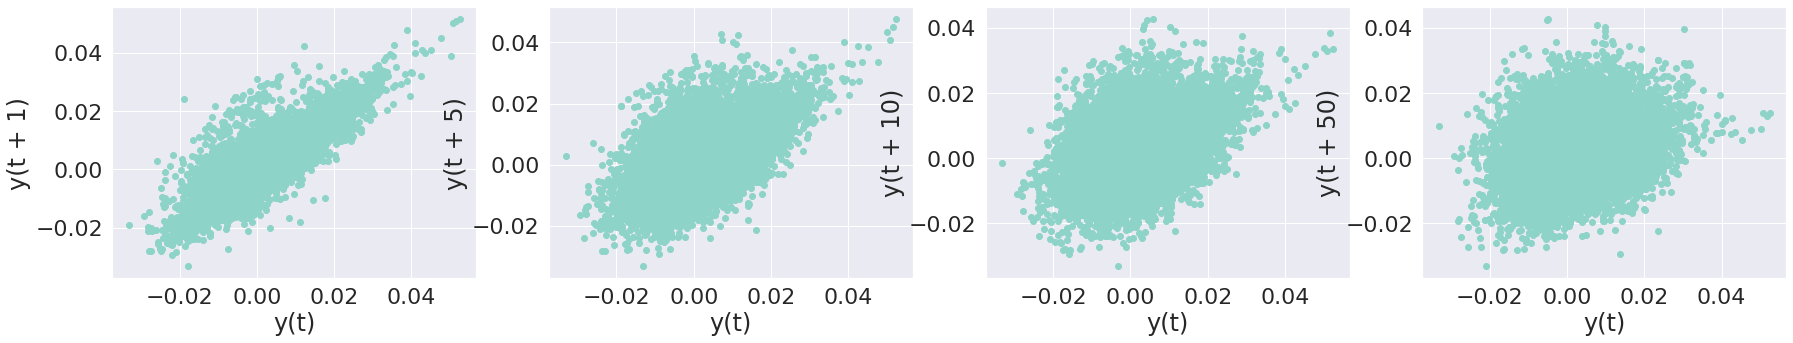

In [124]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
pd.plotting.lag_plot(resid_train_reg1['Error'].iloc[1:], lag=1, ax=axes[0])
pd.plotting.lag_plot(resid_train_reg1['Error'].iloc[1:], lag=5, ax=axes[1])
pd.plotting.lag_plot(resid_train_reg1['Error'].iloc[1:], lag=10, ax=axes[2])
pd.plotting.lag_plot(resid_train_reg1['Error'].iloc[1:], lag=50, ax=axes[3])

- ACF: 파란색 음영을 벗어나고 있으므로 자기상관이 있다 -> 약한 상관성
- PACF: 자기상관이 존재한다 -> 강한 상관성

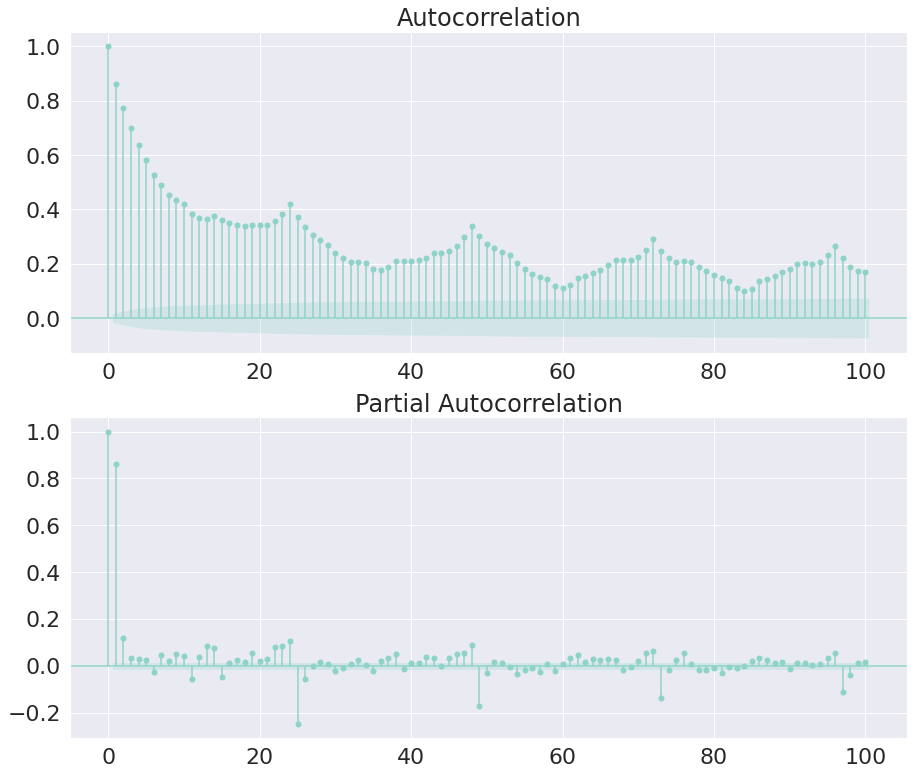

In [125]:
figure, axes = plt.subplots(2, 1, figsize=(15, 13))
figure = sm.graphics.tsa.plot_acf(resid_train_reg1['Error'].iloc[1:], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(resid_train_reg1['Error'].iloc[1:], lags=100, use_vlines=True, ax=axes[1])

**정상성 검정: ADF**

In [126]:
stationary_adf = pd.Series(sm.tsa.stattools.adfuller(resid_train_reg1['Error'])[0:4], index = ['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])

for key, value in sm.tsa.stattools.adfuller(resid_train_reg1['Error'])[4].items():
    stationary_adf['Critical Values(%s)' %key] = value

stationary_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(resid_train_reg1['Error'])[5]
stationary_adf = pd.DataFrame(stationary_adf, columns=['stationary_adf'])
stationary_adf

,stationary_adf
Test Statistics,-1.076529e+01
p-value,2.461504e-19
Used Lag,4.100000e+01
Used Observations,1.308600e+04
Critical Values(1%),-3.430850e+00
Critical Values(5%),-2.861761e+00
Critical Values(10%),-2.566888e+00
Maximum Information Criteria,-1.041510e+05


**정상성 검정: KPSS**

In [127]:
stationary_kpss = pd.Series(sm.tsa.stattools.kpss(resid_train_reg1['Error'])[0:3], index = ['Test Statistics', 'p-value', 'Used Lag'])

for key, value in sm.tsa.stattools.kpss(resid_train_reg1['Error'])[3].items():
    stationary_kpss['Critical Values(%s)' %key] = value

stationary_kpss = pd.DataFrame(stationary_kpss, columns=['stationary_kpss'])
stationary_kpss

,stationary_kpss
Test Statistics,0.089045
p-value,0.100000
Used Lag,41.000000
Critical Values(10%),0.347000
Critical Values(5%),0.463000
Critical Values(2.5%),0.574000
Critical Values(1%),0.739000


**정규성 검정: Shapiro**

p-value가 0이므로 정규분포가 아니다.

In [128]:
normality = pd.DataFrame([stats.shapiro(resid_train_reg1['Error'])],
                        index=['Normality'], columns=['Test Statistics', 'p-value']).T
normality

,Normality
Test Statistics,0.006699
p-value,0.000000


**자기상관 검정: Ljung-Box**

In [129]:
autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(resid_train_reg1['Error'], lags=[1, 5, 10, 50])[0], columns=['Test Statistic']),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(resid_train_reg1['Error'], lags=[1, 5, 10, 50])[1], columns=['p-value'])], axis=1).T

autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']
autocorrelation

,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50)
Test Statistic,0.001014,0.014526,0.051732,0.130667
p-value,0.974594,0.999999,1.000000,1.000000


**등분산성 검정: GoldFeld-Quandt**

In [130]:
heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(resid_train_reg1['Error'], X_train.values, alternative='two-sided')],
                                 index=['Heteroscedasticity'], columns=['Test Statistic', 'p-value', 'Alternative']).T
heteroscedasticity

,Heteroscedasticity
Test Statistic,0.0
p-value,0.0
Alternative,two-sided


In [131]:
score = pd.concat([stationary_adf, stationary_kpss, normality, autocorrelation, heteroscedasticity], join='outer', axis=1)
score.reindex(['Test Statistics', 'p-value', 'Alternative','Used Lag', 'Used Observations', 'Critical Values(1%)', 'Critical Values(5%)', 'Critical Values(10%)', 'Maximum Information Criteria'])

,stationary_adf,stationary_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-1.076529e+01,0.089045,0.006699,NaN,NaN,NaN,NaN,NaN
p-value,2.461504e-19,0.100000,0.000000,0.974594,0.999999,1.0,1.0,0.0
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided
Used Lag,4.100000e+01,41.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,1.308600e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Values(1%),-3.430850e+00,0.739000,NaN,NaN,NaN,NaN,NaN,NaN
Critical Values(5%),-2.861761e+00,0.463000,NaN,NaN,NaN,NaN,NaN,NaN
Critical Values(10%),-2.566888e+00,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,-1.041510e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
def residual_diagnosis(y_train, pred_train):
    resid_train = pd.DataFrame(y_train.values.flatten() - pred_train, index=y_train.index, columns=['Error'])
    resid_train['RowNum'] = resid_train.reset_index().index
    
    # 백색잡음 확인
    sns.set(palette='coolwarm', color_codes=True, font_scale=2)
    sns.lmplot(data=resid_train.iloc[1:], x='RowNum', y='Error', fit_reg=True, line_kws={'color': 'red'}, size=5.1, aspect=2, ci=99, sharey=True)
    
    # 정규성 확인
    normality = pd.DataFrame([stats.shapiro(resid_train['Error'])],
                        index=['Normality'], columns=['Test Statistics', 'p-value']).T
    
    # 자기상관 확인
    figure, axes = plt.subplots(2, 1, figsize=(15, 13))
    figure = sm.graphics.tsa.plot_acf(resid_train['Error'].iloc[1:], lags=100, use_vlines=True, ax=axes[0])
    figure = sm.graphics.tsa.plot_pacf(resid_train['Error'].iloc[1:], lags=100, use_vlines=True, ax=axes[1])
    autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(resid_train['Error'], lags=[1, 5, 10, 50])[0], columns=['Test Statistic']),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(resid_train['Error'], lags=[1, 5, 10, 50])[1], columns=['p-value'])], axis=1).T
    autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']
    
    # 정상성 확인 1
    stationary_adf = pd.Series(sm.tsa.stattools.adfuller(resid_train['Error'])[0:4], index = ['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in sm.tsa.stattools.adfuller(resid_train['Error'])[4].items():
        stationary_adf['Critical Values(%s)' %key] = value
    stationary_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(resid_train['Error'])[5]
    stationary_adf = pd.DataFrame(stationary_adf, columns=['stationary_adf'])
    
    # 정상성 확인 2
    stationary_kpss = pd.Series(sm.tsa.stattools.kpss(resid_train['Error'])[0:3], index = ['Test Statistics', 'p-value', 'Used Lag'])
    for key, value in sm.tsa.stattools.kpss(resid_train['Error'])[3].items():
        stationary_kpss['Critical Values(%s)' %key] = value
    stationary_kpss = pd.DataFrame(stationary_kpss, columns=['stationary_kpss'])
    
    # 등분산성 확인
    heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(resid_train['Error'], X_train.values, alternative='two-sided')],
                                 index=['Heteroscedasticity'], columns=['Test Statistic', 'p-value', 'Alternative']).T
    
    score = pd.concat([stationary_adf, stationary_kpss, normality, autocorrelation, heteroscedasticity], join='outer', axis=1)
    score.reindex(['Test Statistics', 'p-value', 'Alternative','Used Lag', 'Used Observations', 'Critical Values(1%)', 'Critical Values(5%)', 'Critical Values(10%)', 'Maximum Information Criteria'])

    return score

## 5. 정상성 변환

계절성 제거 및 정상성 확인한 후 비정상 시계열이라면 차분을 진행하여 정상적 시계열로 변환해준다.

### 5-1. 로그변환

로그변환을 통해 큰 값은 작게, 작은 값은 크게 조정한다.

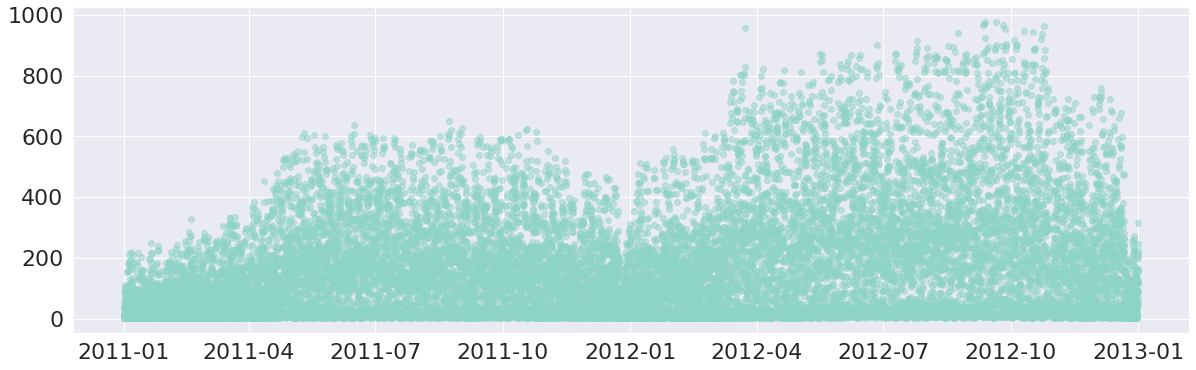

In [133]:
plt.figure(figsize=(20, 6))
plt.scatter(data.index, data['Count'],alpha=0.5)

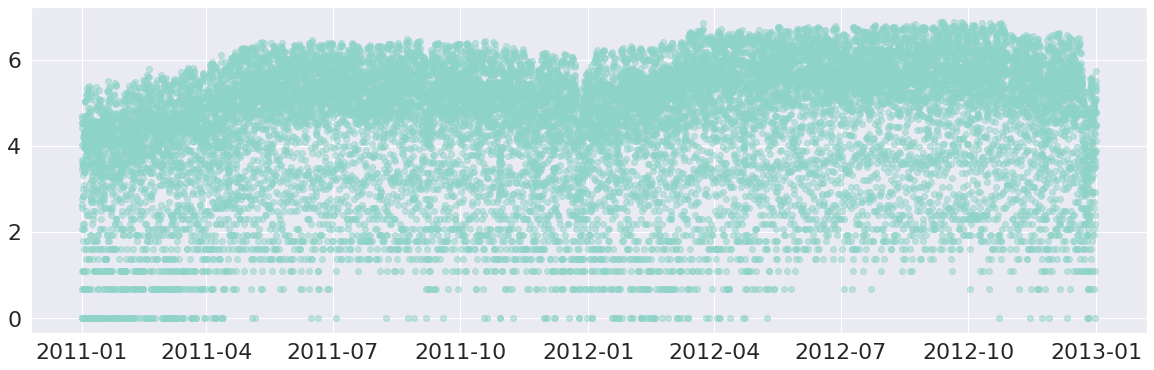

In [134]:
cnt_log = np.log(data['Count'])
plt.figure(figsize=(20, 6))
plt.scatter(data.index, cnt_log, alpha=0.5)

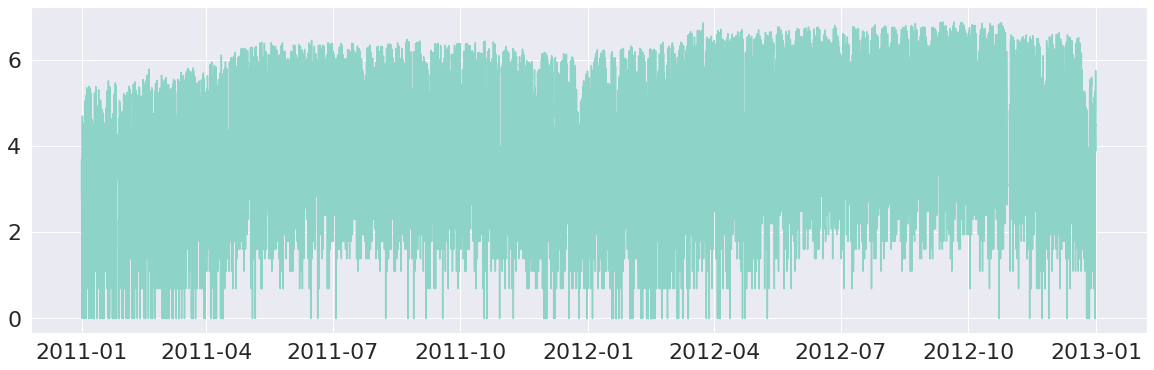

In [135]:
plt.figure(figsize=(20, 6))
plt.plot(data.index, cnt_log)
plt.show()

### 5-2. 차분

현재 시점의 데이터에서 인접 시점의 데이터를 차감하는 차분을 진행한다.

**차분 - np.diff(data) 방법**

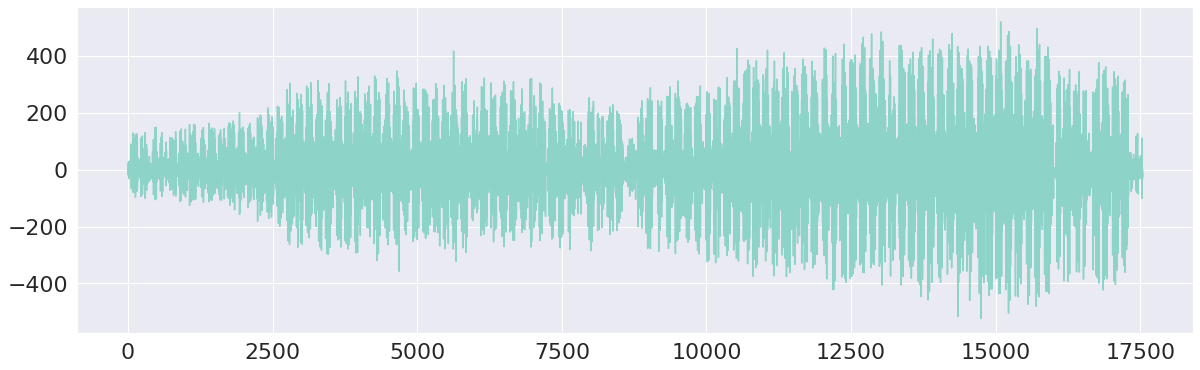

In [136]:
cnt = data['Count']
cnt_diff = np.diff(cnt)
plt.figure(figsize=(20, 6))
plt.plot(cnt_diff) 
plt.show()

**차분 - data.diff() 방법**

차분을 하면 빈 값이 생기므로 그 전의 데이터로 채워준다.

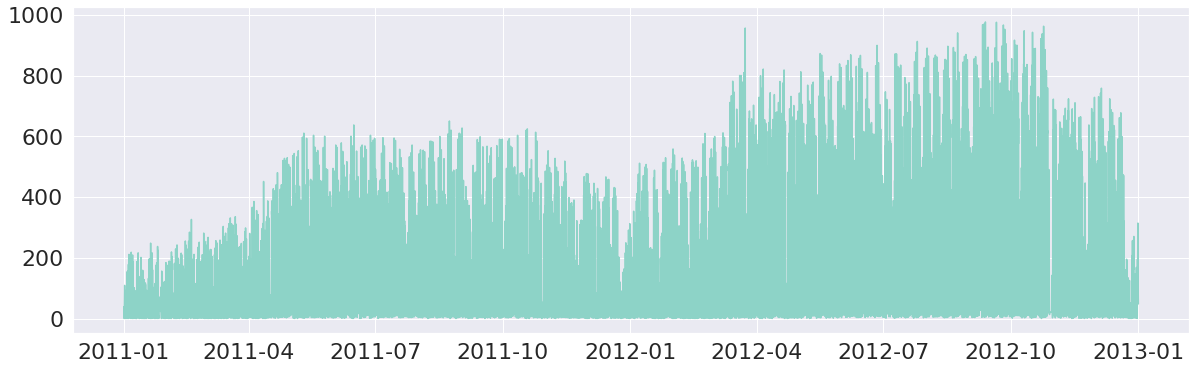

In [137]:
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['Count'])
plt.show()

<AxesSubplot:title={'center':'diff1(log(Y))'}, xlabel='datetime'>

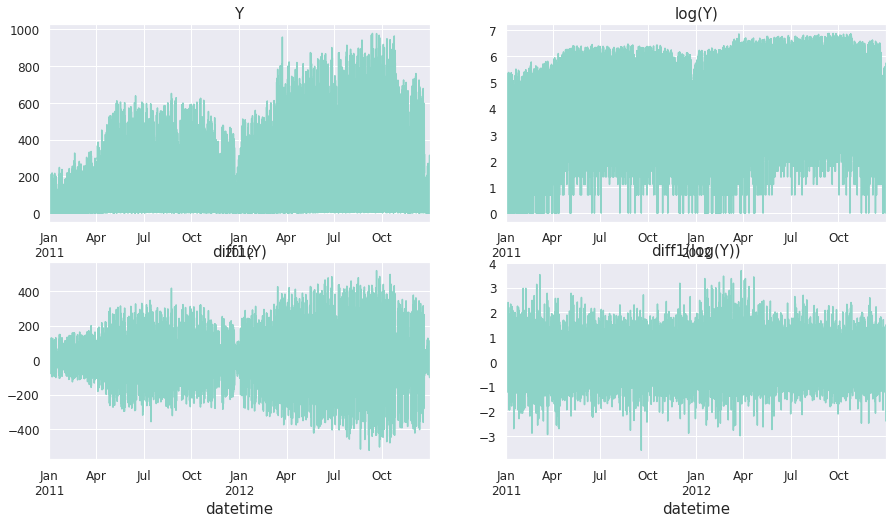

In [138]:
plt.figure(figsize=(15, 8))
plt.rcParams.update({'axes.labelsize': 15, 'axes.titlesize': 15, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

data['Count'].plot(ax=plt.subplot(221), title='Y', legend=False)
np.log(data['Count']).plot(ax=plt.subplot(222), title='log(Y)', legend=False)
data['Count'].diff(1).plot(ax=plt.subplot(223), title='diff1(Y)', legend=False)
np.log(data['Count']).diff(1).plot(ax=plt.subplot(224), title='diff1(log(Y))', legend=False)

In [139]:
data['Count'] = np.log(data['Count']).diff()
data['Count'].fillna(method='bfill', inplace=True)
data['Count']

datetime
2011-01-01 00:00:00    0.916291
2011-01-01 01:00:00    0.916291
2011-01-01 02:00:00   -0.223144
2011-01-01 03:00:00   -0.900787
2011-01-01 04:00:00   -2.564949
                         ...   
2012-12-31 19:00:00   -0.024898
2012-12-31 20:00:00   -0.290487
2012-12-31 21:00:00    0.011173
2012-12-31 22:00:00   -0.388936
2012-12-31 23:00:00   -0.219054
Freq: H, Name: Count, Length: 17544, dtype: float64

In [140]:
X_train, y_train, X_test, y_test = data_split(data)
fit_reg2 = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()

pred_train_reg2 = fit_reg2.predict(X_train).values
pred_test_reg2 = fit_reg2.predict(X_test).values

In [141]:
fit_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     277.6
Date:                Wed, 18 Aug 2021   Prob (F-statistic):               0.00
Time:                        15:21:37   Log-Likelihood:                -11343.
No. Observations:               13128   AIC:                         2.274e+04
Df Residuals:                   13103   BIC:                         2.292e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0002      0.011     -0.016      0.987      -0.022       0.022
yr                -0.0031      0.005     -0.588      0.557      -0.014       0.007
mnth               0.0017      0.003      0.501      0.616      -0.005       0.008
hr                 0.0016      0.000      3.200      0.001       0.001       0.003
holiday           -0.0050      0.038     -0.134      0.893      -0.079       0.068
weekday            0.0033      0.003      1.191      0.234      -0.002       0.009
workingday         0.0096      0.019      0.501      0.617      -0.028       0.047
weathersit        -0.0470      0.009     -4.963      0.000      -0.066      -0.028
temp              -0.6346      0.235     -2.704      0.007      -1.095      -0.175
atemp              0.3035      0.252      1.203      0.229      -0.191       0.798
hum                0.2035      0.033      6.134      0.000       0.138       0.269
windspeed          0.0372      0.046      0.817      0.414      -0.052       0.126
Count_trend        0.0005      0.000      2.241      0.025    6.63e-05       0.001
Count_seasonal     0.0010   7.03e-05     14.210      0.000       0.001       0.001
Count_day          0.0003      0.000      1.258      0.208      -0.000       0.001
Count_week         0.0006      0.000      2.104      0.035    3.78e-05       0.001
Count_diff         0.0036   7.96e-05     45.536      0.000       0.003       0.004
Year           -2.673e-05    2.1e-05     -1.275      0.202   -6.78e-05    1.44e-05
Quater             0.0033      0.020      0.164      0.870      -0.036       0.042
Quater_cum        -0.0093      0.005     -1.713      0.087      -0.020       0.001
Month              0.0017      0.003      0.501      0.616      -0.005       0.008
Day                0.0003      0.001      0.508      0.611      -0.001       0.001
Hour               0.0016      0.000      3.200      0.001       0.001       0.003
DayofWeek         -0.0032      0.005     -0.705      0.481      -0.012       0.006
Count_lag1        -0.0001   7.42e-05     -1.795      0.073      -0.000    1.23e-05
Count_lag2        -0.0006    7.1e-05     -8.693      0.000      -0.001      -0.000
Quater_Dummy_2     0.0239      0.015      1.566      0.117      -0.006       0.054
Quater_Dummy_3     0.0494      0.015      3.387      0.001       0.021       0.078
Quater_Dummy_4    -0.0398      0.014     -2.888      0.004      -0.067      -0.013
==============================================================================
Omnibus:                     2241.981   Durbin-Watson:                   1.456
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12821.313
Skew:                           0.700   Prob(JB):                         0.00
Kurtosis:                       7.635   Cond. No.                     1.11e+16
================================

In [142]:
data_pred = pd.concat([y_train, pd.DataFrame(pred_train_reg2, index=y_train.index, columns=['prediction'])], axis=1)
data_pred

,Count,prediction
datetime,,
2011-01-01 00:00:00,0.916291,0.005908
2011-01-01 01:00:00,0.916291,-0.005356
2011-01-01 02:00:00,-0.223144,-0.131900
2011-01-01 03:00:00,-0.900787,-0.211821
2011-01-01 04:00:00,-2.564949,-0.180993
...,...,...
2012-06-30 19:00:00,0.098256,0.089152
2012-06-30 20:00:00,-0.247502,-0.378662
2012-06-30 21:00:00,-0.315462,-0.430641


<AxesSubplot:xlabel='datetime'>

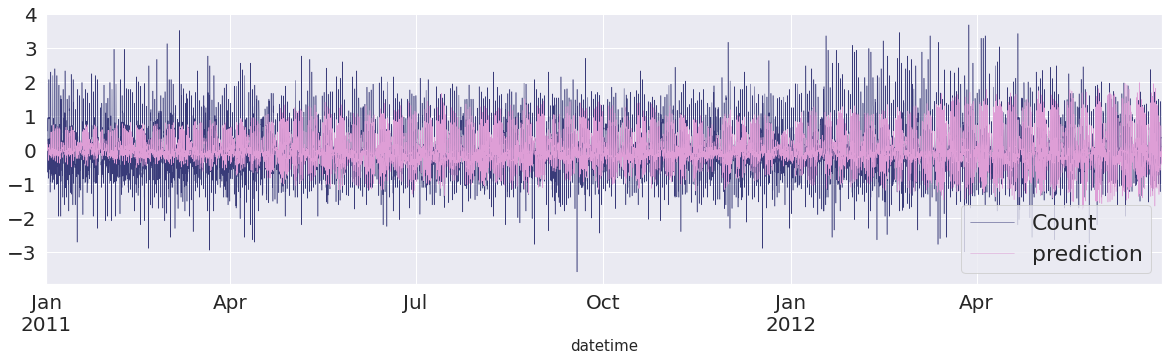

In [143]:
data_pred.plot(kind='line', figsize=(20, 5), xlim=(y_train.index.min(), y_train.index.max()), linewidth=0.5, fontsize=20, colormap='tab20b')

In [144]:
evaluation(y_train, pred_train_reg2)

(0.3646554962952731, 0.3296253281530114, inf)

,stationary_adf,stationary_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-1.383510e+01,0.105605,0.899026,NaN,NaN,NaN,NaN,NaN
p-value,7.468279e-26,0.100000,0.000000,3.283788e-213,0.000000,0.000000,0.000000,0.001245
Used Lag,4.100000e+01,41.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,1.308600e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Values(1%),-3.430850e+00,0.739000,NaN,NaN,NaN,NaN,NaN,NaN
Critical Values(5%),-2.861761e+00,0.463000,NaN,NaN,NaN,NaN,NaN,NaN
Critical Values(10%),-2.566888e+00,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,1.474659e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Values(2.5%),NaN,0.574000,NaN,NaN,NaN,NaN,NaN,NaN
Test Statistic,NaN,NaN,NaN,9.711911e+02,2051.600153,2311.391731,15762.668964,1.083123


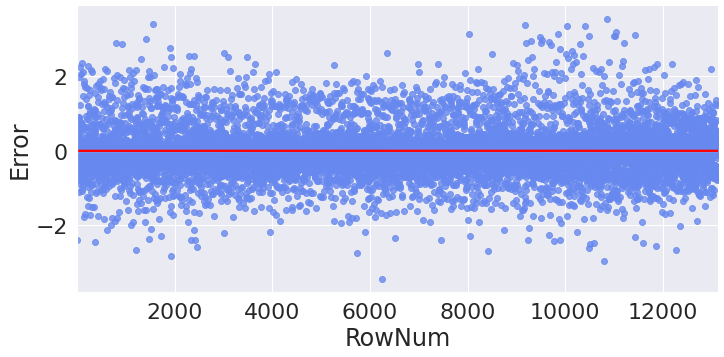

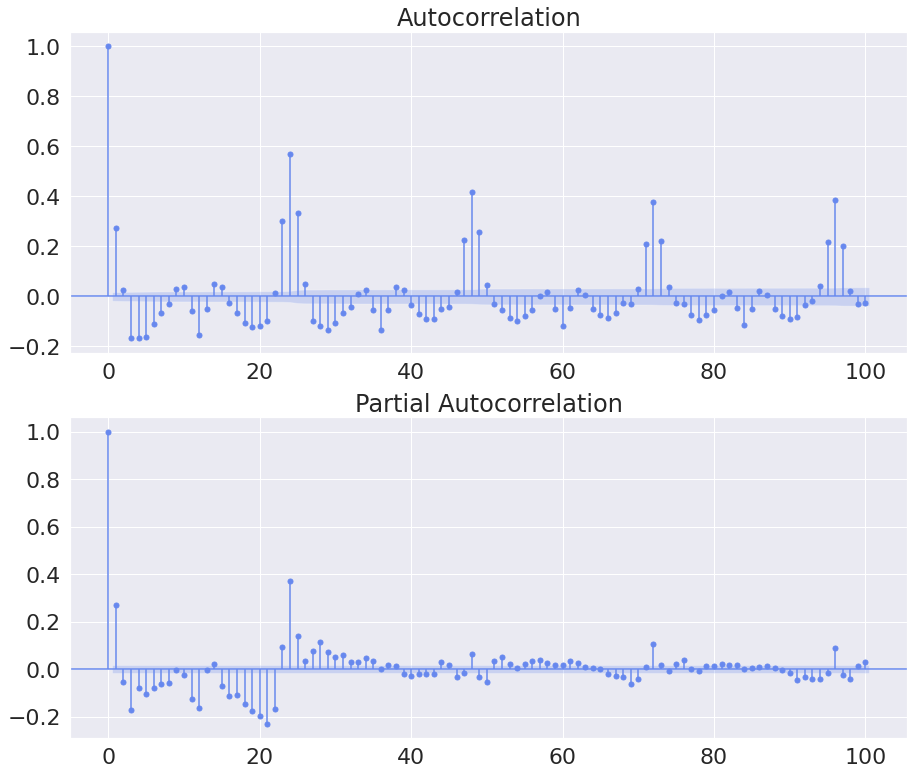

In [145]:
residual_diagnosis(y_train, pred_train_reg2)

## 모델 적합

ACF, PACF 그래프에서 0에 수렴하는 속도가 느리기 때문에 ARIMA 모델을 적합시키기에 적합한 데이터는 아니지만 ARIMA 모델에 적합하는 경우에는 다음과 같이 진행하게 된다.

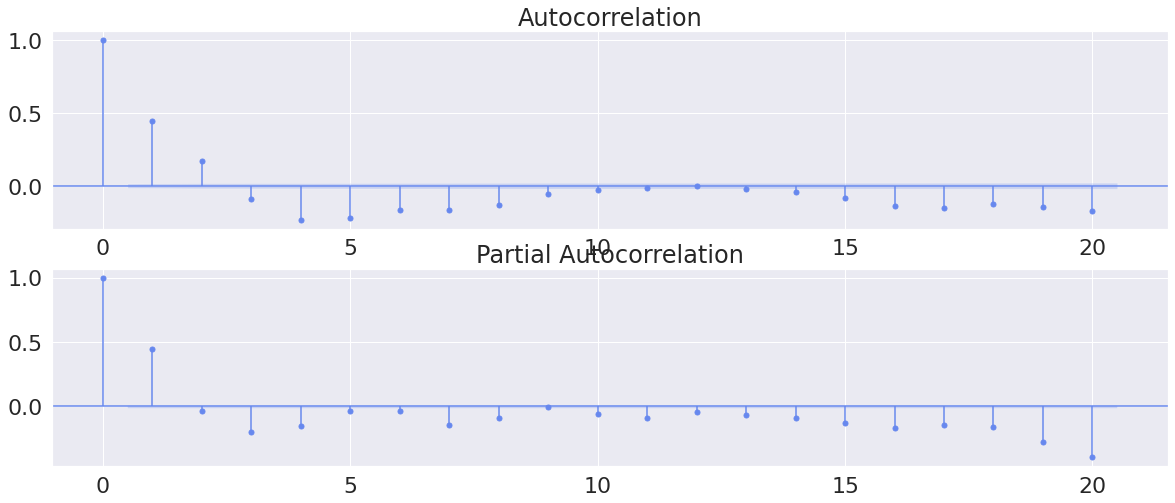

In [146]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Count'][1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Count'][1:], lags=20, ax=ax2)

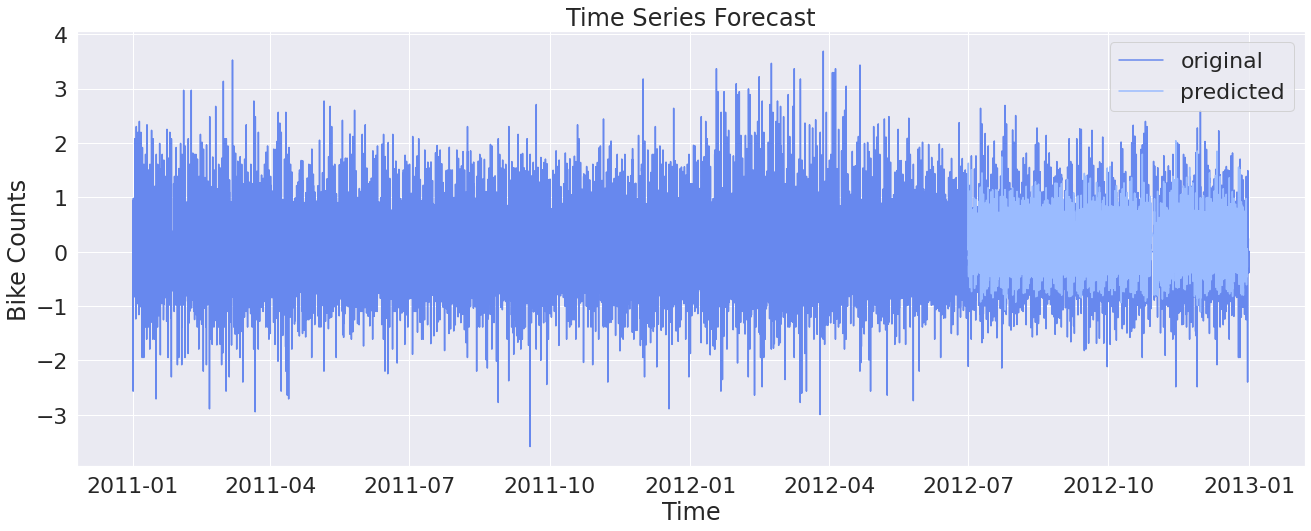

In [151]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data['Count'], order=(2, 1, 2))
model_fit = model.fit()

forecast = model_fit.predict(start=datetime(2012, 7, 1), end=datetime(2012, 12, 31))

plt.figure(figsize=(22, 8))
plt.plot(data['Count'], label='original')
plt.plot(forecast, label='predicted')
plt.title('Time Series Forecast')
plt.xlabel('Time')
plt.ylabel('Bike Counts')
plt.legend()
plt.show()